This first cell is reserved for package importation. 

A small comment will be added to each import statement, summarizing the usage of the package in this notebook.

A requirements.txt will be generated at the end of the notebook and bundled along with it to enable ease of installation.

To perform an installation of all the required packages, you can first initialize a new venv, either in conda or vanilla Python.

Then, simply run: ```pip install -r requirements.txt```

In [33]:
import numpy as np #Matrix operations and linear algebra
import matplotlib.pyplot as plt #Basic plotting utilities
import pandas as pd #Dataframe data type, manipulation and general utilities
pd.set_option('display.max_row', 1000) #Display many rows
seed = 123 #For reproducibility
from sklearn.preprocessing import PolynomialFeatures #Create features up to degree X
from sklearn.linear_model import LinearRegression, Ridge #The linear regression model that can also be used for polynomial regression
from sklearn.metrics import mean_squared_error #Well, this is quite self explanatory
import warnings #Ignoring sklearn
warnings.filterwarnings('ignore') 
from statsmodels.tsa.arima.model import ARIMA #ARIMA, make sure the latest version is available to avoid unnecessary convergence errors in SVD

First, the data has to be imported. The John's Hopkins University dataset will be used.

The dataset can be easily obtained from this [Github repository](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data).

In order to load the data into the notebook, the Pandas library will be used, as it provides convenient functions to read .csv files off the internet.

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-05-2020.csv')

Afterwards, some cursory Exploratory Data Analysis will be conducted in order to familiarise with the dataset.

Namely, first the dataframes themselves will be examined, so as to obtain a rough idea of the structure of the data.

This part will also be conducted in pandas, since it provides native functionality for exactly such tasks.

In [3]:
print("Checking the latest data provided. Printing its head. It is of shape {}".format(latest_data.shape))
print("\n")
print(latest_data.head())
print("\n")
print("Printing the column names")
print("\n")
print("\n".join(list(latest_data.columns)))
print("-"*100)
print("Checking the data about the confirmed cases. Printing its head. It is of shape {}".format(confirmed_df.shape))
print("\n")
print(confirmed_df.head())
print("\n")
print("Printing the column names")
print("\n")
print("\n".join(list(confirmed_df.columns)[1:10]))
print("-"*100)
print("Checking the data about the confirmed deaths. Printing its head. It is of shape {}".format(deaths_df.shape))
print("\n")
print(deaths_df.head())
print("\n")
print("Printing the column names")
print("\n")
print("\n".join(list(deaths_df.columns)[1:10]))
print("-"*100)
print("Checking the data about the confirmed recoveries. Printing its head. It is of shape {}".format(recoveries_df.shape))
print("\n")
print(recoveries_df.head())
print("\n")
print("Printing the column names")
print("\n")
print("\n".join(list(recoveries_df.columns)[1:10]))

Checking the latest data provided. Printing its head. It is of shape (2764, 12)


      FIPS     Admin2  Province_State Country_Region          Last_Update  \
0  45001.0  Abbeville  South Carolina             US  2020-04-05 23:06:45   
1  22001.0     Acadia       Louisiana             US  2020-04-05 23:06:45   
2  51001.0   Accomack        Virginia             US  2020-04-05 23:06:45   
3  16001.0        Ada           Idaho             US  2020-04-05 23:06:45   
4  19001.0      Adair            Iowa             US  2020-04-05 23:06:45   

         Lat       Long_  Confirmed  Deaths  Recovered  Active  \
0  34.223334  -82.461707          6       0          0       0   
1  30.295065  -92.414197         75       2          0       0   
2  37.767072  -75.632346         11       0          0       0   
3  43.452658 -116.241552        385       3          0       0   
4  41.330756  -94.471059          1       0          0       0   

                    Combined_Key  
0  Abbeville, South Car

As it seems, the data is structured as following:

1. A Province/State column, which will not be utilized, as the data will be modeled on the national scale.

2. A Country/Region column that will serve as the basis by which to split the data along nations.

3. A latitude and longtitude column that are both rendered redundant through the Country/Region column.

4. Several columns depicting daily statistics.

It should be noted that the structure between the dataframes for the confirmed cases, deaths and recoveries are all constructed in the same way, making them quite easy to use.

As for the daily statistics dataframe, it will not be utilized in the present assignment, as the training data will be up to the 20th of March, 2020.

It seems a new column is added every day.

First, the datetime should be converted 

First, the unneeded province/state column will be deleted and so will the latitude and longitude columns.

In [4]:
deaths_df = deaths_df.drop(columns = ["Province/State","Lat","Long"])
confirmed_df = confirmed_df.drop(columns = ["Province/State","Lat","Long"])
recoveries_df = recoveries_df.drop(columns = ["Province/State","Lat","Long"])

Furthermore, the dates should be converted to an integer representation.

In [5]:
names = dict(zip(list(deaths_df.columns[1:]),list(range(1,len(deaths_df.columns[1:])+1)))) #Creating a he integers for all the days, zipping them with the days into a dictionary.
deaths_df = deaths_df.rename(columns = names)
confirmed_df = confirmed_df.rename(columns = names)
recoveries_df = recoveries_df.rename(columns = names)

Since the data will be dealth with in a nation-wide scale, the names of the regions should be examined.

In [6]:
print(deaths_df['Country/Region'])

0                           Afghanistan
1                               Albania
2                               Algeria
3                               Andorra
4                                Angola
5                   Antigua and Barbuda
6                             Argentina
7                               Armenia
8                             Australia
9                             Australia
10                            Australia
11                            Australia
12                            Australia
13                            Australia
14                            Australia
15                            Australia
16                              Austria
17                           Azerbaijan
18                              Bahamas
19                              Bahrain
20                           Bangladesh
21                             Barbados
22                              Belarus
23                              Belgium
24                                Benin


It seems there are duplicates. As per the assumptions, they will be summed up into one entry per country.

In [7]:
deaths_df = deaths_df.groupby(deaths_df['Country/Region']).sum()
confirmed_df = confirmed_df.groupby(confirmed_df['Country/Region']).sum()
recoveries_df = recoveries_df.groupby(recoveries_df['Country/Region']).sum()

A function is created that performs all the necessary tests and returns the model objects.

This function takes as an argument:

The dataset, which is the confirmed cases

The country of interest, one of the row names of the dataset

The desired degree of the polynomial models

The criterion to be used (AIC or BIC)

Whether to consider using the days index when predicting (Boolean)

Whether to consider the previous 3 days when predicting (Boolean)

Whether to consider the confirmed deaths and recoveries when predicting for those dates

The date_x parameter as shown in class, indexed in its integer form (available through the names variable)

The regularization parameter λ for Ridge Regression

Whether to output diagnostic messages at many steps (Boolean)

In [8]:
def create_polynomial_models(dataset = confirmed_df, country = "Italy",degrees = list(range(2,10)),
                             criterion = "BIC", consider_days = True, consider_previous = True,
                             other_datasets = [recoveries_df,deaths_df], date_x = names['3/20/20'],
                             regularization = 0.9,verbose = True, names = names,plot = True):
    np.random.seed(seed) #Seed of reproducibility

    chosen_country = dataset.loc[country] #Select only the country of interest
    chosen_country = chosen_country[0:date_x] #Select up to the date of interest

    training_days = np.random.choice(np.arange(4,(len(chosen_country)-1)),int(0.66*(len(chosen_country)-5)),replace = False) #Select the 66 percent for training. Start from 4 to incorporate previous days
    testing_days = np.array([x for x in np.arange(4,(len(chosen_country)-1)) if x not in training_days]) #Use list comprehension to obtain the rest of the indices (Testing)

    #Beginning the machine learning part
    training_data = chosen_country[training_days] #Create the training data array 
    training_targets = chosen_country[training_days + 1] #Create the "next day" array, the value the model tries to predict

    testing_data = chosen_country[testing_days] #Create the testing data array
    testing_targets = chosen_country[testing_days + 1] #Create the "next day" array for the testing data

    if consider_days == True: #Flag to consider the day index
        training_data = np.transpose(np.vstack([training_data,training_days])) #Stack the day integer with the actual training data
        testing_data = np.transpose(np.vstack([testing_data,testing_days]))

    #Add new axes (Required by polynomial features). If you use consider days, this is already functional
    else:
        training_data = training_data[:, np.newaxis]
        testing_data = testing_data[:, np.newaxis]

    best_model = None #Placeholder variable for the best model
    best_crit = np.Inf #Placeholder variable for the best AIC/BIC
    best_degree = 0 #placeholder variable for the degre
    best_preds = None #Placeholder for the best predicton values

    if verbose == True: #Verbosity flag   
        if regularization != 0: #Regularization flag
            print("Using regularization with a λ of {}".format(regularization))
        else:
            print("Not using regularization")

        if consider_days == True: #Consider true diagnostic flag
            print("Using the day index")
        else:
            print("Not using the day index")

        if consider_previous == True: #Previous days diagnostic flag
            print("Using previous days for computation")
        else:
            print("Not using the previous days for computation")


    if other_datasets is not None:
        if verbose == True:
            print("Using recovered and deaths datasets for prediction as well")
            
        chosen_country_deaths = other_datasets[0].loc[country] #Select only the country of interest
        chosen_country_deaths = chosen_country_deaths[0:date_x] #Select up to the date of interest
        chosen_country_recover = other_datasets[1].loc[country] #Select only the country of interest
        chosen_country_recover = chosen_country_recover[0:date_x] #Select up to the date of interest
    else:
        if verbose == True:
            print("Not using recovered and deaths datasets")

    if verbose == True:
        print("\n") #Tidy the output

    for degree in degrees: #Iterate over all degrees

        polynomial_features= PolynomialFeatures(degree=degree) #Create the object that creates the features
        #Fit on both datasets
        training_data_poly = polynomial_features.fit_transform(training_data)
        testing_data_poly = polynomial_features.fit_transform(testing_data)

        if consider_previous == True: #Flag
            for i in range(1,4): #One, two and three days before training. Do the same process to generate more features from each of the previous days
                training_days_extra = training_days - i
                training_data_extra = chosen_country[training_days_extra]
                training_data_extra = training_data_extra[:, np.newaxis]
                training_data_poly_extra = polynomial_features.fit_transform(training_data_extra)
                training_data_poly = np.hstack([training_data_poly,training_data_poly_extra]) #Append the new features. This should create n*3 features, where n is degree.
                #Do the same for testing
                testing_days_extra = testing_days - i
                testing_data_extra = chosen_country[testing_days_extra]
                testing_data_extra = testing_data_extra[:, np.newaxis]
                testing_data_poly_extra = polynomial_features.fit_transform(testing_data_extra)
                testing_data_poly = np.hstack([testing_data_poly,testing_data_poly_extra])

        if other_datasets is not None: #Apply the exact same transformations to create more features
            #First for the training data
            training_data_recovered = chosen_country_recover[training_days]
            training_data_recovered = training_data_recovered[:, np.newaxis]
            training_data_poly_recovered = polynomial_features.fit_transform(training_data_recovered)
            training_data_poly = np.hstack([training_data_poly,training_data_poly_recovered])
            training_data_deaths = chosen_country_deaths[training_days]
            training_data_deaths = training_data_deaths[:, np.newaxis]
            training_data_poly_deaths = polynomial_features.fit_transform(training_data_deaths)
            training_data_poly = np.hstack([training_data_poly,training_data_poly_recovered])
            #Next, for the testing data
            testing_data_recovered = chosen_country_recover[testing_days]
            testing_data_recovered = testing_data_recovered[:, np.newaxis]
            testing_data_poly_recovered = polynomial_features.fit_transform(testing_data_recovered)
            testing_data_poly = np.hstack([testing_data_poly,testing_data_poly_recovered])
            testing_data_deaths = chosen_country_deaths[testing_days]
            testing_data_deaths = testing_data_deaths[:, np.newaxis]
            testing_data_poly_deaths = polynomial_features.fit_transform(testing_data_deaths)
            testing_data_poly = np.hstack([testing_data_poly,testing_data_poly_recovered])

        if regularization == 0: #Flag for regularization
            model = LinearRegression() #Create the model object
        else:
            model = Ridge(alpha = regularization) #Iincorporating regularization if needed

        if verbose == True:
            print(training_data_poly.shape) #Diagnostic statement for the shape of the data

        model.fit(training_data_poly, training_targets) #Fit the model

        training_preds = model.predict(training_data_poly) #Create predictions for the training dataset
        testing_preds = model.predict(testing_data_poly) #Create predictions for the test dataset

        all_preds = np.concatenate([training_preds,testing_preds])

        rmse_train = np.sqrt(mean_squared_error(training_targets,training_preds)) #Calculating RMSE for the training dataset
        rmse_test = np.sqrt(mean_squared_error(testing_targets,testing_preds)) #Calculating RMSE for the testing dataset

        if verbose == True:
            print("For the model with degree {}, the training RMSE is {} and the testing RMSE is {}.".format(degree,rmse_train,rmse_test))
        #Calculate criteria
        if criterion == "BIC":
            crit = np.log(len(testing_preds))*training_data_poly.shape[1] - 2*np.log(rmse_test)
        elif criterion == "AIC":
            crit = -2*np.log(rmse_test) + 2*training_data_poly.shape[1]
        else:
            print("Criterion must be one of AIC or BIC. Exiting")
            break
        #Select the best model
        if crit < best_crit:
            if verbose == True:
                print("New optimal model found based on {} with a value of {}!".format(criterion,crit))
            best_model = model
            best_crit = crit
            best_preds = all_preds
            best_degree = degree
    
    if plot == True:
        #Creating an ordering variable for the predictied and true values
        sort_by = np.argsort(np.concatenate([training_days,testing_days]))
        #Concatenating training and testing
        all_targets = np.concatenate([training_targets,testing_targets])
        #Sorting by the ordering variable
        all_targets = all_targets[sort_by]
        best_preds = best_preds[sort_by]
        #Plotting stuf
        fig = plt.figure(figsize = (13,13))
        ax1 = fig.add_subplot(111)
        ax1.scatter(np.arange(4,(len(chosen_country)-1)),all_targets,c = "b",label = "True number of cases")
        ax1.plot(np.arange(4,(len(chosen_country)-1)),all_targets,c = "b")
        ax1.scatter(np.arange(4,(len(chosen_country)-1)),best_preds, c = "r", label = "Predicted number of cases")
        ax1.plot(np.arange(4,(len(chosen_country)-1)),best_preds, c = "r")
        plt.legend(loc='upper left')
        plt.ylabel("Number of cases")
        plt.xlabel("Day")
        date_names = names.items()
        date_names = sorted(date_names, key = lambda x: x[1])
        date_names = [x[0] for x in date_names]
        date_names = np.array(date_names)[np.arange(4,(len(chosen_country)-1))]
        date_names = [x[0:-3]for x in date_names]
        plt.xticks(np.arange(4,(len(chosen_country)-1)),date_names,rotation='vertical')
        plt.title("Confirmed cases curve for {}, using a polynomial of degree {} with {}: {}".format(country,best_degree,criterion,best_crit))
        plt.show()    
        
    return(best_model,best_crit,best_degree)



**UPDATE for part 2**

Implemented ARIMA modelling instead of only polynomial fitting. For the ARIMA model, the test set will be all dates after date_x, because data needs to be given in a time-series fashion (temporally linked) instead of random data-points off a distribution that the model tries to approximate. The code is heavily based on [this article](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/). In the next cell, a small evaluation of this model is presented. Only BIC has been implemented for ARIMA model selection as of now.

In [37]:
def create_ARIMA_model(dataset = confirmed_df, country = "Italy",date_x = names['3/20/20'],
                      criterion = "BIC",consider_days = True, p = 5, d = 1, q = 0,verbose = False, plot = True):
    np.random.seed(seed) #Seed of reproducibility

    chosen_country = dataset.loc[country] #Select only the country of interest
    chosen_country = chosen_country[0:date_x] #Select up to the date of interest

    training_days = np.random.choice(np.arange(4,(len(chosen_country)-1)),int(0.66*(len(chosen_country)-5)),replace = False) #Select the 66 percent for training. Start from 4 to incorporate previous days
    testing_days = np.array([x for x in np.arange(4,(len(chosen_country)-1)) if x not in training_days]) #Use list comprehension to obtain the rest of the indices (Testing)

    #Beginning the machine learning part
    training_data = chosen_country[training_days] #Create the training data array 
    training_targets = chosen_country[training_days + 1] #Create the "next day" array, the value the model tries to predict

    testing_data = chosen_country[testing_days] #Create the testing data array
    testing_targets = chosen_country[testing_days + 1] #Create the "next day" array for the testing data

    if consider_days == True: #Flag to consider the day index
        training_data = np.transpose(np.vstack([training_data,training_days])) #Stack the day integer with the actual training data
        testing_data = np.transpose(np.vstack([testing_data,testing_days]))
    training_data = np.vstack([training_data,testing_data]) #Stacking testing and training
    
    training_data = training_data[np.argsort(training_data[:,1])] #Sort by second column (dates)
    
    if verbose == True:
        autocorr_plot = autocorrelation_plot(training_data) #Produces an autocorrelation plot for the data to check how much each observation affects the next
        plt.show()
        
    #Beginning the modelling itself
    training_data = training_data[:,0] #Delete the days column
    
    model = ARIMA(training_data, order=(p,d,q)) #You should run this part after adjusting P, D and Q according to the autocorrelation plot
    model_fit = model.fit()
    
    if verbose == True: #No need to plot them every time
        residuals = DataFrame(model_fit.resid) #Get the residuals
        residuals.plot()
        pyplot.show()
        residuals.plot(kind='kde')
        pyplot.show()
        print(residuals.describe())
    
    #Now we use the model's autoregressive ability to generate many new predictions.
    chosen_country_extra = dataset.loc[country] #Get the row of the country of interest again
    chosen_country_extra = chosen_country_extra[date_x:] #All dates of interest
    
    testing_days = np.array(chosen_country_extra) #Set it as the variable name
    history = [x for x in training_data] #Create the observations
    predictions = list() #Make a new list of predictions
    
    for t in range(len(testing_days)): #For every day
        
        model = ARIMA(history, order=(5,1,0)) #Create a new model with the training data + current predictions
        model_fit = model.fit() #fit it
        
        output = model_fit.forecast() #Get the next prediction
        yhat = output[0] #get the predicted output
        predictions.append(yhat) #Add it to the predictions next round
        obs = testing_days[t] #Check the real value
        history.append(obs) #Append it to allow the model to train on it when predicting the day 2 days from now
        
        if verbose == True:
            print('predicted=%f, expected=%f' % (yhat, obs)) #Diagnostic
            
    #Plotting section, copied from the continued_predictions function and modified
    if plot == True:
        
        #predictions = [x[0] for x in predictions] #Compatibility with older ARIMA version
        history_for_plot = history[date_x-p:]
        
        fig = plt.figure(figsize = (13,13))
        ax1 = fig.add_subplot(111)
        ax1.scatter(np.arange(len(predictions)),history_for_plot,c = "b",label = "True number of cases")
        ax1.plot(np.arange(len(predictions)),history_for_plot,c = "b")
        ax1.scatter(np.arange(len(predictions)),predictions, c = "r", label = "Predicted number of cases (extrapolation)")
        ax1.plot(np.arange(len(predictions)),predictions, c = "r")
        plt.legend(loc='upper left')
        plt.ylabel("Number of cases")
        plt.xlabel("Day")
        date_names = names.items()
        date_names = sorted(date_names, key = lambda x: x[1])
        date_names = [x[0] for x in date_names]
        date_names = np.array(date_names)[np.arange(date_x,(len(predictions)-1+date_x))]
        date_names = [x[0:-3]for x in date_names]
        plt.xticks(np.arange(len(predictions)),date_names,rotation='vertical')
        plt.title("Confirmed cases curve for {}, using ARIMA.".format(country))
        plt.show()
    

[39408.786557501466, 68928.14447498137, 70882.21293134932, 69765.01393995176, 78826.55051220459, 84636.26117284481, 85972.52297119476, 91940.03945863873, 98144.01235346693, 103243.09127333315, 106874.64573111731, 110486.1478910298, 115232.39621394945, 119672.25314844685, 124082.18155889708, 129054.6030858653, 133381.86275191576, 136646.08485144677, 139308.67761093518, 143158.84730419295, 147353.0121018654, 151174.20903938956, 156123.6106358294, 160362.22291364966]


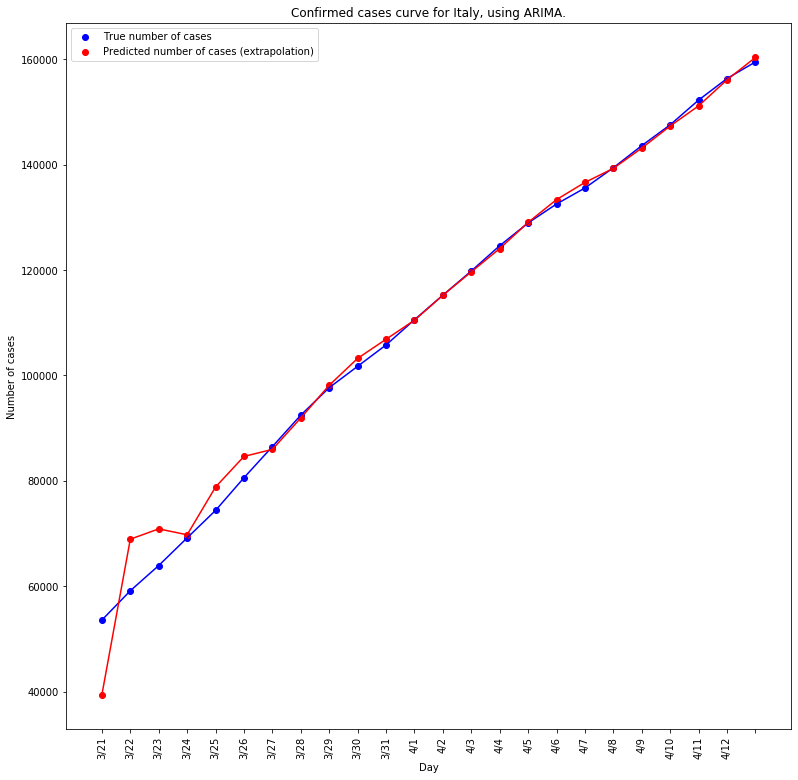

In [39]:
create_ARIMA_model() #Test run

Using regularization with a λ of 0.9
Using the day index
Using previous days for computation
Using recovered and deaths datasets for prediction as well


(43, 21)
For the model with degree 2, the training RMSE is 188.87644523108568 and the testing RMSE is 842.6839501894921.
New optimal model found based on BIC with a value of 52.37219458071618!
(43, 30)
For the model with degree 3, the training RMSE is 85.14143041150203 and the testing RMSE is 2125.4709338052944.
(43, 40)
For the model with degree 4, the training RMSE is 130.1501300469668 and the testing RMSE is 28013.145696167096.
(43, 51)
For the model with degree 5, the training RMSE is 7400.895642498953 and the testing RMSE is 14768.79961541196.
(43, 63)
For the model with degree 6, the training RMSE is 9124.014356791702 and the testing RMSE is 17860.62048519848.
(43, 76)
For the model with degree 7, the training RMSE is 10027.76204266677 and the testing RMSE is 27163.408292559907.
(43, 90)
For the model with degree 8, the training

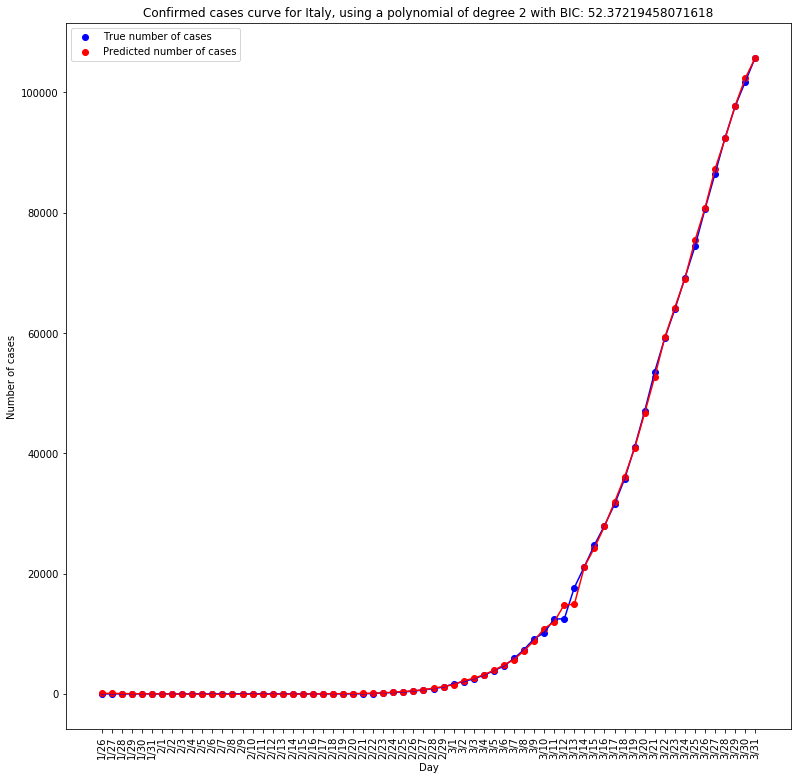

In [10]:
model_crit = create_polynomial_models(country="Italy",date_x = names['4/1/20'],verbose= True) #Test run with default parameters from Greece (using everything)

The function returns quite a lot of warnings at points, because the matrices used are not well behaved at points.

Now, a loop will be created to check over all the conditions and output the best overall model.

This function identifies among all the models the one with the best combination of features, those being degree, usage of the day index, usage of the three previous days, usage of the other datasets and usage of regularization. It also plots the curve. For the best identified model and returns the best combination of parameters.

This function is used for Greece, Italy, Germany, Spain, China and the US.

In [11]:
def identify_best_model(country,verbose = False, date_x = names['3/20/20']):
    best_model = None
    best_crit = np.inf
    best_degree = 0
    use_days = None
    use_previous = None
    use_other = None
    use_reg = None
    for consider_days in [True,False]:
        for consider_previous in [True,False]:
            for other_datasets in [None,[recoveries_df,deaths_df]]:
                for regularization in np.arange(0,1,0.1):
                    data = create_polynomial_models(dataset=confirmed_df,country = country, consider_days = consider_days,
                                                    consider_previous = consider_previous, other_datasets = other_datasets,
                                                    regularization = regularization, verbose = verbose, plot = False,
                                                   date_x = date_x)
                    if data[1] < best_crit:
                        best_crit = data[1]
                        best_model = data[0]
                        best_degree = data[2]
                        use_days = consider_days
                        use_previous = consider_previous
                        use_other = other_datasets
                        use_reg = regularization
    best_params = (best_model,best_degree,best_crit,use_days,use_previous,use_other,use_reg)

    create_polynomial_models(country = country,consider_days=best_params[3],consider_previous = best_params[4], other_datasets= best_params[5],regularization = best_params[6],
                         verbose = False)
    return(best_params)
                        

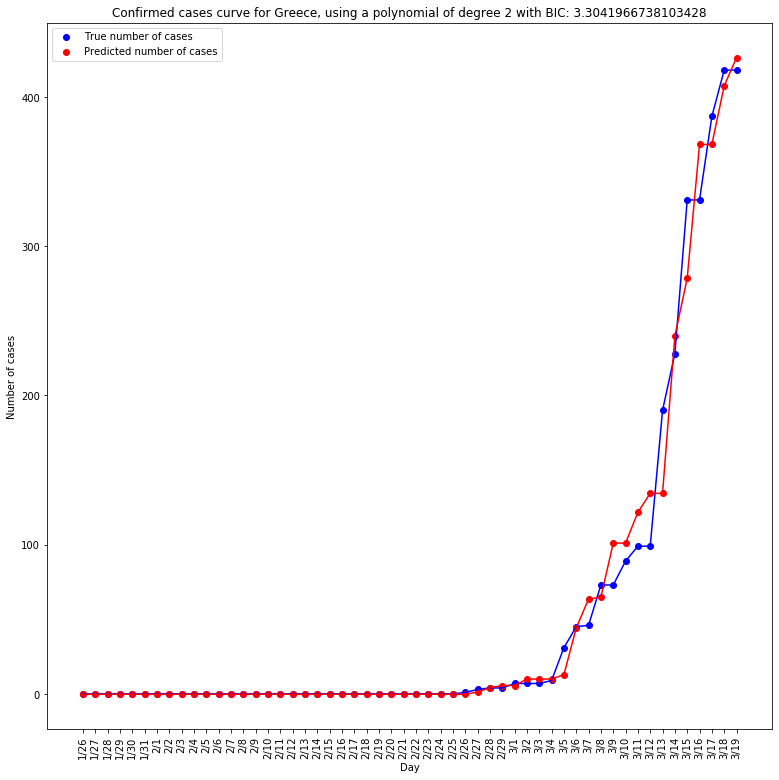

(Ridge(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 2, 3.3041966738103428, False, False, None, 0.9)


In [12]:
country = "Greece"
best_params_greece = identify_best_model(country,date_x = names['3/20/20'])
print(best_params_greece)

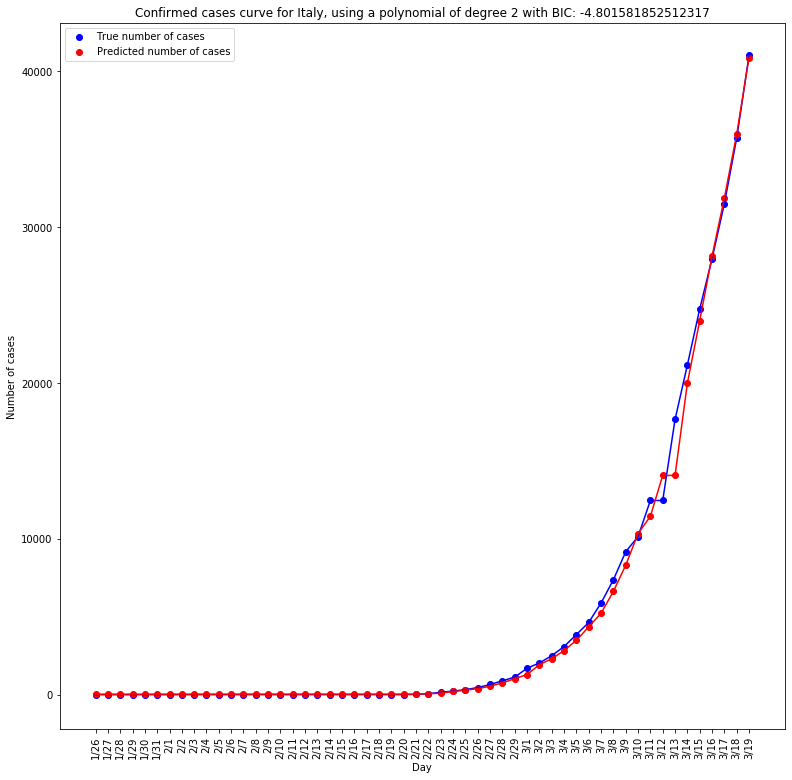

(Ridge(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 2, -4.801581852512317, False, False, None, 0.9)


In [13]:
country = "Italy"
best_params_italy = identify_best_model(country,date_x = names['3/20/20'])
print(best_params_italy)

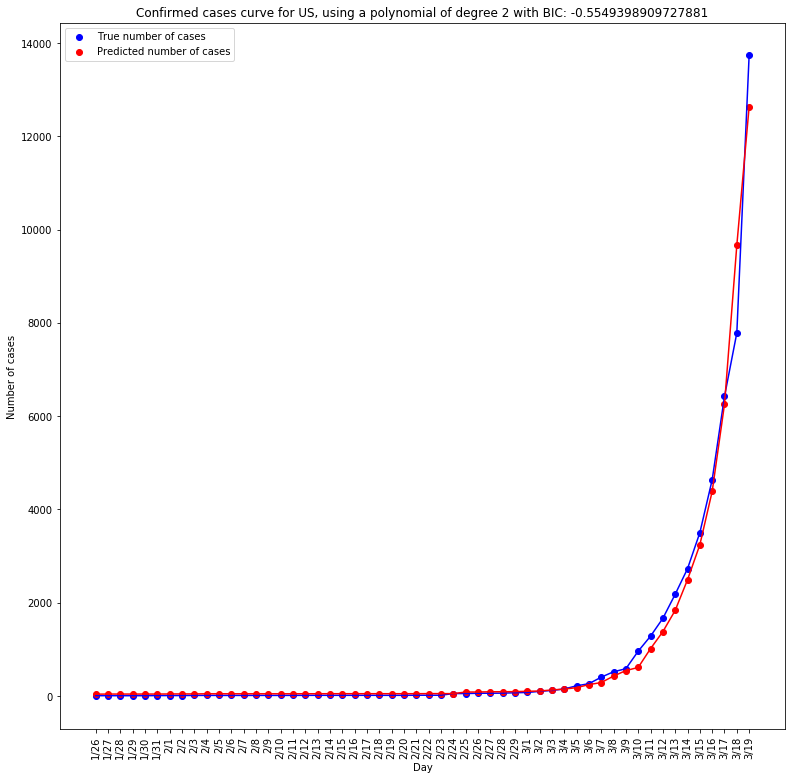

(Ridge(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 2, -0.5549398909727881, False, False, None, 0.9)


In [14]:
country = "US"
best_params_usa = identify_best_model(country,date_x = names['3/20/20'])
print(best_params_usa)

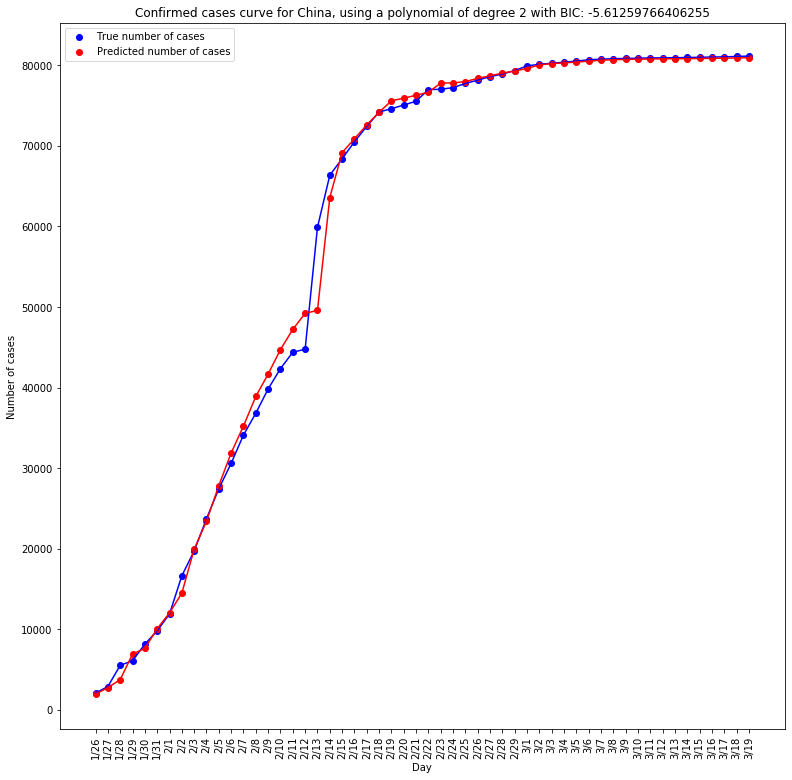

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 2, -5.61259766406255, False, False, None, 0.0)


In [15]:
country = "China"
best_params_china = identify_best_model(country)
print(best_params_china)

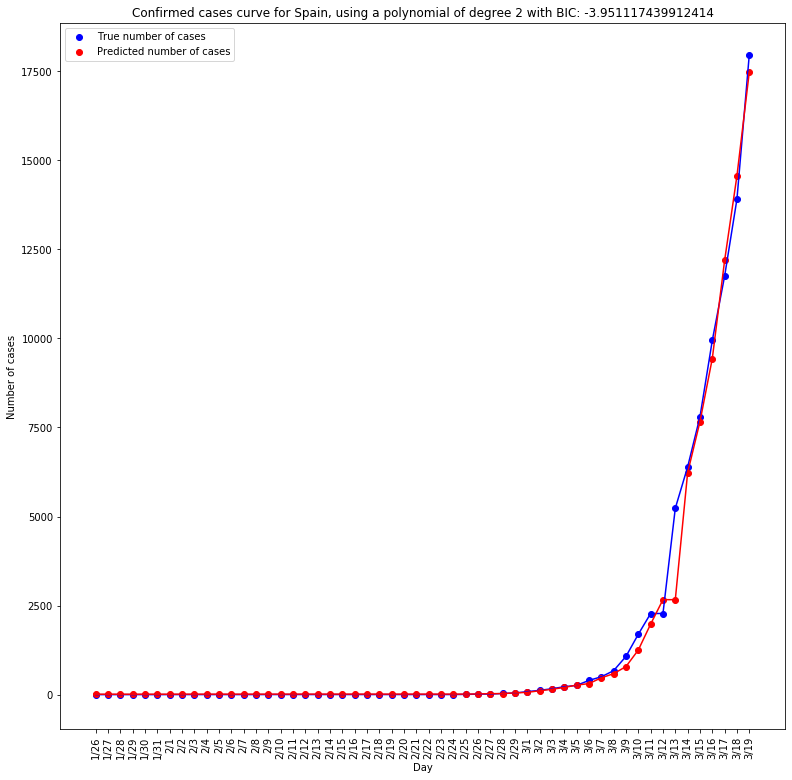

(Ridge(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 2, -3.951117439912414, False, False, None, 0.9)


In [16]:
country = "Spain"
best_params_spain = identify_best_model(country)
print(best_params_spain)

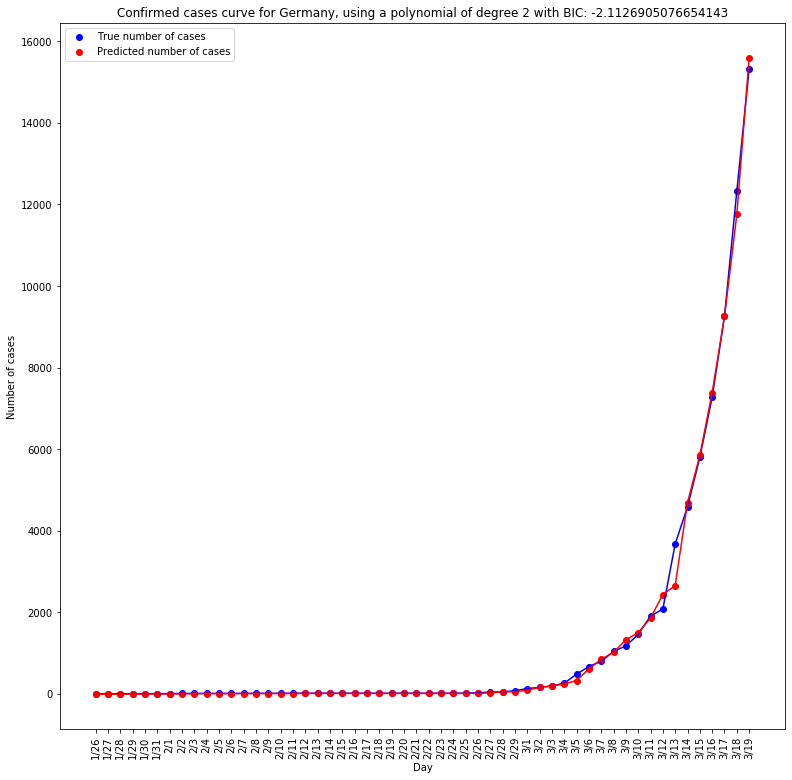

(Ridge(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 2, -2.1126905076654143, False, False, None, 0.9)


In [17]:
country = "Germany"
best_params_germany = identify_best_model(country)
print(best_params_germany)

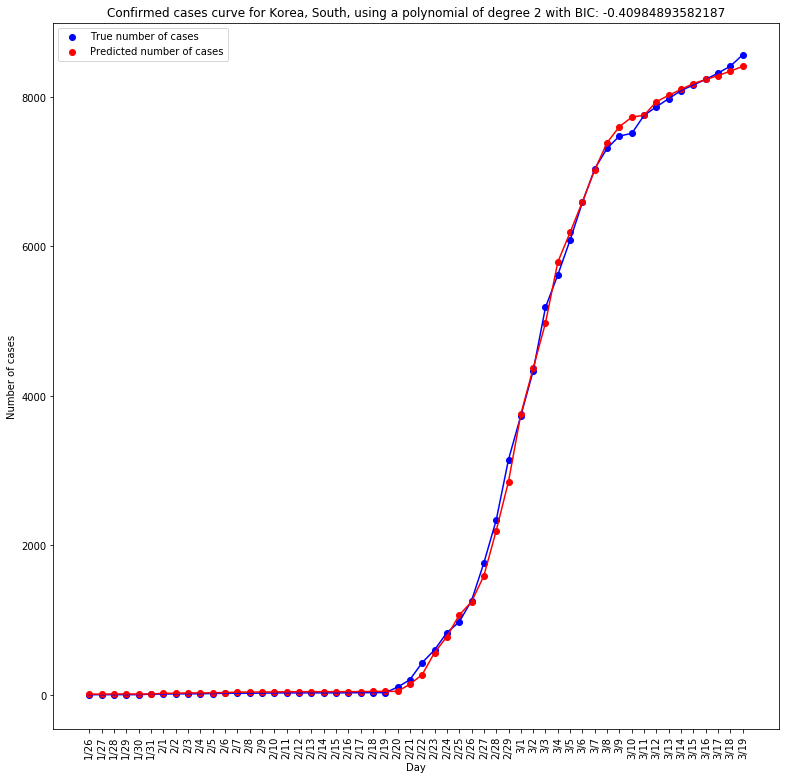

(Ridge(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 2, -0.40984893582187, False, False, None, 0.9)


In [18]:
country = "Korea, South"
best_params_skor = identify_best_model(country)
print(best_params_skor)

Not using regularization
Using the day index
Using previous days for computation
Not using recovered and deaths datasets


(35, 15)
For the model with degree 2, the training RMSE is 1.3071248441820942 and the testing RMSE is 2.157815610198309.
New optimal model found based on BIC with a value of 42.62839185065485!
(35, 22)
For the model with degree 3, the training RMSE is 0.9102492668382297 and the testing RMSE is 2.100718482892953.
(35, 30)
For the model with degree 4, the training RMSE is 0.4678029786208038 and the testing RMSE is 2.1066208170008394.
(35, 39)
For the model with degree 5, the training RMSE is 3.5451235033446204e-06 and the testing RMSE is 29.998638377022743.
(35, 49)
For the model with degree 6, the training RMSE is 3.0779696528921654e-06 and the testing RMSE is 23.948050593022842.
(35, 60)
For the model with degree 7, the training RMSE is 0.00021953684195779455 and the testing RMSE is 146.23015668047776.
(35, 72)
For the model with degree 8, the training RMSE is 0.00

For the model with degree 9, the training RMSE is 3.1758168122103845 and the testing RMSE is 33.643893425008166.
Using regularization with a λ of 0.8
Using the day index
Using previous days for computation
Not using recovered and deaths datasets


(35, 15)
For the model with degree 2, the training RMSE is 1.3106347030040184 and the testing RMSE is 2.1381531731393384.
New optimal model found based on BIC with a value of 42.64669978104422!
(35, 22)
For the model with degree 3, the training RMSE is 0.9196838185176436 and the testing RMSE is 2.0700495620523185.
(35, 30)
For the model with degree 4, the training RMSE is 0.6332072760343682 and the testing RMSE is 2.981607350328762.
(35, 39)
For the model with degree 5, the training RMSE is 0.8519082972930815 and the testing RMSE is 9.535113532557423.
(35, 49)
For the model with degree 6, the training RMSE is 1.3177324446038257 and the testing RMSE is 5.639358179303562.
(35, 60)
For the model with degree 7, the training RMSE is 1.615856592261

For the model with degree 9, the training RMSE is 3.1191354978114174 and the testing RMSE is 25.243727383582204.
Using regularization with a λ of 0.6000000000000001
Using the day index
Using previous days for computation
Using recovered and deaths datasets for prediction as well


(35, 21)
For the model with degree 2, the training RMSE is 1.3041289192753174 and the testing RMSE is 2.1615545572136825.
New optimal model found based on BIC with a value of 60.29156323199879!
(35, 30)
For the model with degree 3, the training RMSE is 0.9174214918288793 and the testing RMSE is 2.0733363951290706.
(35, 40)
For the model with degree 4, the training RMSE is 0.5292979527511532 and the testing RMSE is 4.0312087019762695.
(35, 51)
For the model with degree 5, the training RMSE is 0.8776530428449297 and the testing RMSE is 10.4217499151277.
(35, 63)
For the model with degree 6, the training RMSE is 1.2707387821164458 and the testing RMSE is 5.521044160732531.
(35, 76)
For the model with degree 7, t

(35, 55)
For the model with degree 9, the training RMSE is 3.2368625960252606 and the testing RMSE is 6.191804720372983.
Using regularization with a λ of 0.8
Using the day index
Not using the previous days for computation
Not using recovered and deaths datasets


(35, 6)
For the model with degree 2, the training RMSE is 1.590318148688539 and the testing RMSE is 1.9693599597262448.
New optimal model found based on BIC with a value of 16.311216682157482!
(35, 10)
For the model with degree 3, the training RMSE is 1.1178300055819894 and the testing RMSE is 1.5743958629372976.
(35, 15)
For the model with degree 4, the training RMSE is 0.8414725543045701 and the testing RMSE is 1.6376026078955987.
(35, 21)
For the model with degree 5, the training RMSE is 0.6971080700820643 and the testing RMSE is 1.2697462433247895.
(35, 28)
For the model with degree 6, the training RMSE is 0.4013487520303234 and the testing RMSE is 1.8297833180496847.
(35, 36)
For the model with degree 7, the training RMSE

For the model with degree 9, the training RMSE is 3.2284029377598005 and the testing RMSE is 6.102980980763262.
Using regularization with a λ of 0.6000000000000001
Using the day index
Not using the previous days for computation
Using recovered and deaths datasets for prediction as well


(35, 12)
For the model with degree 2, the training RMSE is 1.565007464749828 and the testing RMSE is 1.866818610156896.
New optimal model found based on BIC with a value of 34.084796341879944!
(35, 18)
For the model with degree 3, the training RMSE is 1.106703025507707 and the testing RMSE is 1.5700862977541659.
(35, 25)
For the model with degree 4, the training RMSE is 0.792315284845383 and the testing RMSE is 1.5977243943655903.
(35, 33)
For the model with degree 5, the training RMSE is 0.6773879834483779 and the testing RMSE is 1.279841877485847.
(35, 42)
For the model with degree 6, the training RMSE is 1.611142933581899 and the testing RMSE is 1.8285716556102596.
(35, 52)
For the model with degree

(35, 12)
For the model with degree 2, the training RMSE is 1.701641582926855 and the testing RMSE is 2.8085950245328872.
New optimal model found based on BIC with a value of 33.267899015919475!
(35, 16)
For the model with degree 3, the training RMSE is 1.097508676570547 and the testing RMSE is 1.9931436611435316.
(35, 20)
For the model with degree 4, the training RMSE is 0.946686573313668 and the testing RMSE is 1.912071447981636.
(35, 24)
For the model with degree 5, the training RMSE is 0.8631107298537871 and the testing RMSE is 1.5884816445982692.
(35, 28)
For the model with degree 6, the training RMSE is 0.8365539963148466 and the testing RMSE is 1.3692178196363876.
(35, 32)
For the model with degree 7, the training RMSE is 0.8049733872637448 and the testing RMSE is 3.7595973905275457.
(35, 36)
For the model with degree 8, the training RMSE is 4.988176963078338 and the testing RMSE is 5.26057842265129.
(35, 40)
For the model with degree 9, the training RMSE is 5.572511116811112 and

For the model with degree 5, the training RMSE is 1.5512502156919066 and the testing RMSE is 1.6524534548394454.
(35, 42)
For the model with degree 6, the training RMSE is 2.210727017720133 and the testing RMSE is 3.016357011426878.
(35, 48)
For the model with degree 7, the training RMSE is 3.08444526609254 and the testing RMSE is 6.824577799962647.
(35, 54)
For the model with degree 8, the training RMSE is 4.962557905145711 and the testing RMSE is 5.794973258468397.
(35, 60)
For the model with degree 9, the training RMSE is 5.572511116811112 and the testing RMSE is 7.563499158456265.
Using regularization with a λ of 0.30000000000000004
Not using the day index
Using previous days for computation
Using recovered and deaths datasets for prediction as well


(35, 18)
For the model with degree 2, the training RMSE is 1.7010911929045294 and the testing RMSE is 2.8038273367204334.
New optimal model found based on BIC with a value of 50.93793084542148!
(35, 24)
For the model with degree 3, th

For the model with degree 6, the training RMSE is 1.1279930187418354 and the testing RMSE is 1.614299292941949.
(35, 8)
For the model with degree 7, the training RMSE is 1.1018176863685933 and the testing RMSE is 1.7316146561497079.
(35, 9)
For the model with degree 8, the training RMSE is 1.0260337255985812 and the testing RMSE is 1.5661462523845409.
(35, 10)
For the model with degree 9, the training RMSE is 0.9688037685239128 and the testing RMSE is 1.426296770442624.
Using regularization with a λ of 0.2
Not using the day index
Not using the previous days for computation
Not using recovered and deaths datasets


(35, 3)
For the model with degree 2, the training RMSE is 2.962165136037755 and the testing RMSE is 2.4353769880077176.
New optimal model found based on BIC with a value of 7.053113807323038!
(35, 4)
For the model with degree 3, the training RMSE is 2.3705381212218666 and the testing RMSE is 2.701181386610916.
(35, 5)
For the model with degree 4, the training RMSE is 1.468815

(35, 30)
For the model with degree 9, the training RMSE is 1.1713214621461805 and the testing RMSE is 1.6465156132164975.
Using regularization with a λ of 0.1
Not using the day index
Not using the previous days for computation
Using recovered and deaths datasets for prediction as well


(35, 9)
For the model with degree 2, the training RMSE is 2.9120705226074572 and the testing RMSE is 2.5894614985925224.
New optimal model found based on BIC with a value of 24.597050935512648!
(35, 12)
For the model with degree 3, the training RMSE is 2.366027313641112 and the testing RMSE is 2.7408485424249522.
(35, 15)
For the model with degree 4, the training RMSE is 1.3744421324467535 and the testing RMSE is 1.6155362311763324.
(35, 18)
For the model with degree 5, the training RMSE is 1.1767847552359827 and the testing RMSE is 1.4627780678944176.
(35, 21)
For the model with degree 6, the training RMSE is 1.122673719868108 and the testing RMSE is 1.5816454579271284.
(35, 24)
For the model with degr

(35, 12)
For the model with degree 3, the training RMSE is 2.366065147956678 and the testing RMSE is 2.7376828466152467.
(35, 15)
For the model with degree 4, the training RMSE is 1.3750575284842823 and the testing RMSE is 1.6268075930333654.
(35, 18)
For the model with degree 5, the training RMSE is 1.1769836244288148 and the testing RMSE is 1.4634288840413532.
(35, 21)
For the model with degree 6, the training RMSE is 1.1259036327741399 and the testing RMSE is 1.5624493001855078.
(35, 24)
For the model with degree 7, the training RMSE is 1.0798578001654229 and the testing RMSE is 1.720770320791825.
(35, 27)
For the model with degree 8, the training RMSE is 1.0515474814113595 and the testing RMSE is 1.6616869370683542.
(35, 30)
For the model with degree 9, the training RMSE is 0.9740942010099148 and the testing RMSE is 1.4300598178647292.


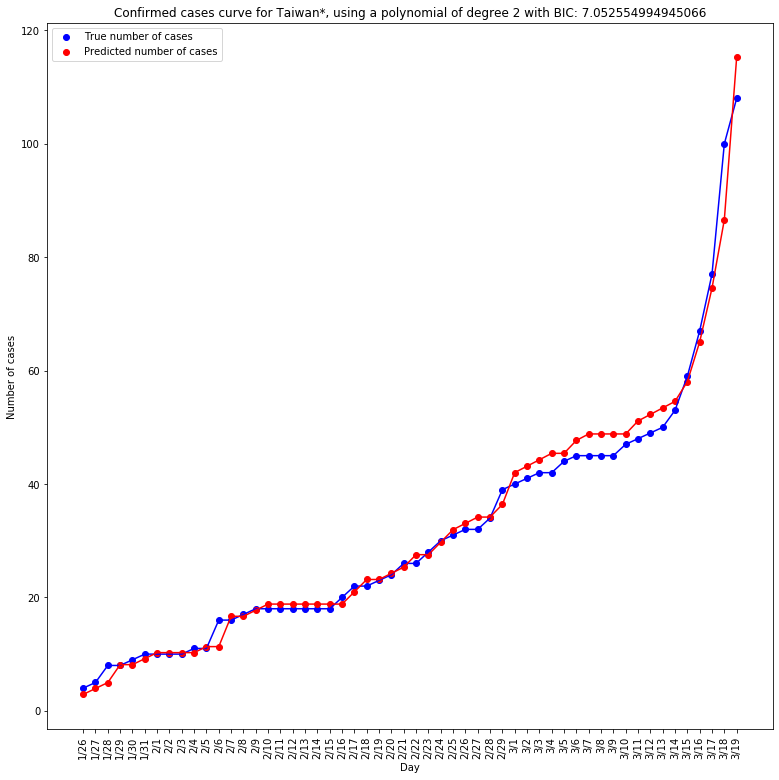

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 2, 7.052554994945066, False, False, None, 0.0)


In [19]:
country = "Taiwan*"
best_params_taiwan = identify_best_model(country,verbose = True)
print(best_params_taiwan)

The function in the cell below is a more general case of the subroutine described here.
First, the object holding the model parameters is given, along with the country and the date_x
Afterwards, predictions are generated for all dates after date_x by utilizing the previous day's
prediction only. Next, the data is plotted. Three examples follow, for Italy, US and Greece.

In [20]:
def continued_predictions(country,model,date_x):
    
    model_country = model[0]
    chosen_country = confirmed_df.loc[country] #Select only the country of interest
    chosen_country = chosen_country[date_x:] #Select up to the date of interest (date_X) to now
    target_data = chosen_country[1:] #The data we want to predict (delete first so we can make prediction)
    extra_data = chosen_country[:-1,np.newaxis] #Delete last and add a new axis
    polynomial_features= PolynomialFeatures(degree=int(model[1])) #Create the object that creates the features
    extra_data = polynomial_features.fit_transform(extra_data)
    preds = model_country.predict(extra_data)
    fig = plt.figure(figsize = (13,13))
    ax1 = fig.add_subplot(111)
    ax1.scatter(np.arange((len(chosen_country)-1)),target_data,c = "b",label = "True number of cases")
    ax1.plot(np.arange((len(chosen_country)-1)),target_data,c = "b")
    ax1.scatter(np.arange((len(chosen_country)-1)),preds, c = "r", label = "Predicted number of cases (extrapolation)")
    ax1.plot(np.arange((len(chosen_country)-1)),preds, c = "r")
    plt.legend(loc='upper left')
    plt.ylabel("Number of cases")
    plt.xlabel("Day")
    date_names = names.items()
    date_names = sorted(date_names, key = lambda x: x[1])
    date_names = [x[0] for x in date_names]
    date_names = np.array(date_names)[np.arange(date_x,(len(chosen_country)-1+date_x))]
    date_names = [x[0:-3]for x in date_names]
    plt.xticks(np.arange((len(chosen_country)-1)),date_names,rotation='vertical')
    plt.title("Confirmed cases curve for {}, using a polynomial of degree {}.".format(country,model[1]))
    plt.show()
    return(preds)

Since Italy seemed to be on an exponential phase of the virus, the model overestimates the number of predicted cases

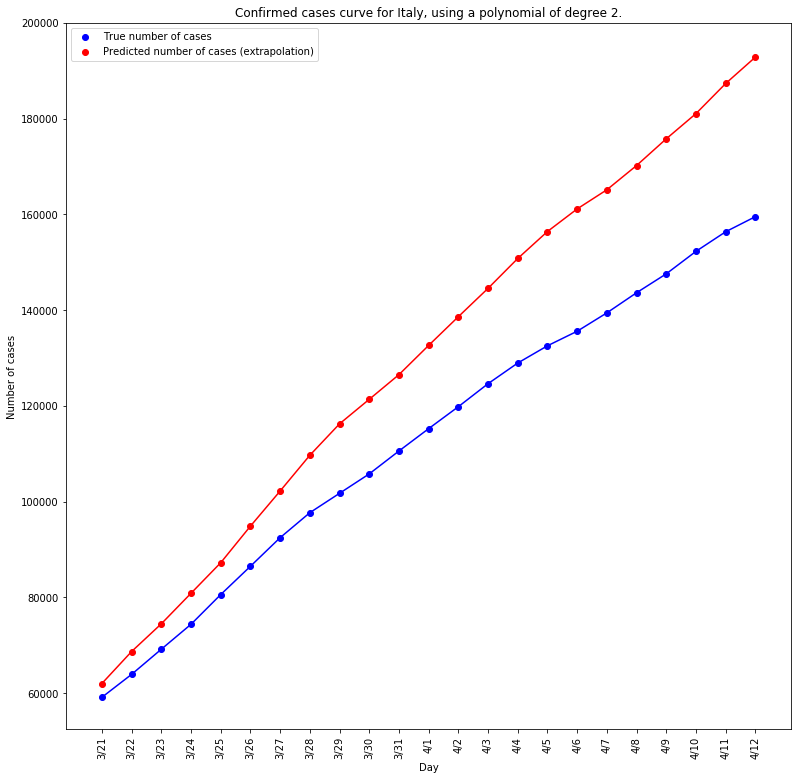

array([ 62019.94183661,  68696.08825713,  74483.12129151,  80864.9943649 ,
        87239.75864801,  94881.88964078, 102214.75268603, 109680.79057178,
       116243.95120945, 121366.7495209 , 126517.63602434, 132626.24828465,
       138621.86593721, 144542.26038567, 150780.10591552, 156412.25224511,
       161129.82415712, 165128.26995752, 170194.84574348, 175772.47737907,
       181038.2769108 , 187324.34691952, 192830.83050583])

In [21]:
continued_predictions("Italy",best_params_italy,names['3/20/20'])

When compared to the extrapolation by the polynomial model above, it can be easily seen that the ARIMA model clearly outperforms it.

[39408.786557501466, 68928.14447498137, 70882.21293134932, 69765.01393995176, 78826.55051220459, 84636.26117284481, 85972.52297119476, 91940.03945863873, 98144.01235346693, 103243.09127333315, 106874.64573111731, 110486.1478910298, 115232.39621394945, 119672.25314844685, 124082.18155889708, 129054.6030858653, 133381.86275191576, 136646.08485144677, 139308.67761093518, 143158.84730419295, 147353.0121018654, 151174.20903938956, 156123.6106358294, 160362.22291364966]


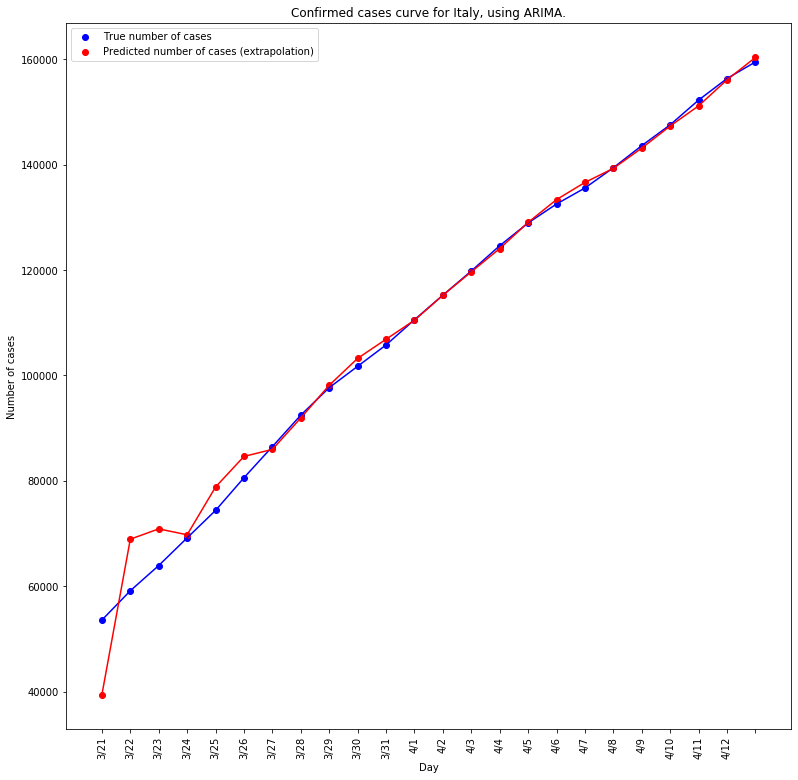

In [40]:
create_ARIMA_model()

However, in the case of Greece, since the data the model was trained on suggested a decline in the number of cases, the extrapolation is wildly off with respect to the actual number of cases. The model underestimates. The results are so outrageous that in fact the model predicts negative numbers of cases, which should be thoroughly impossible

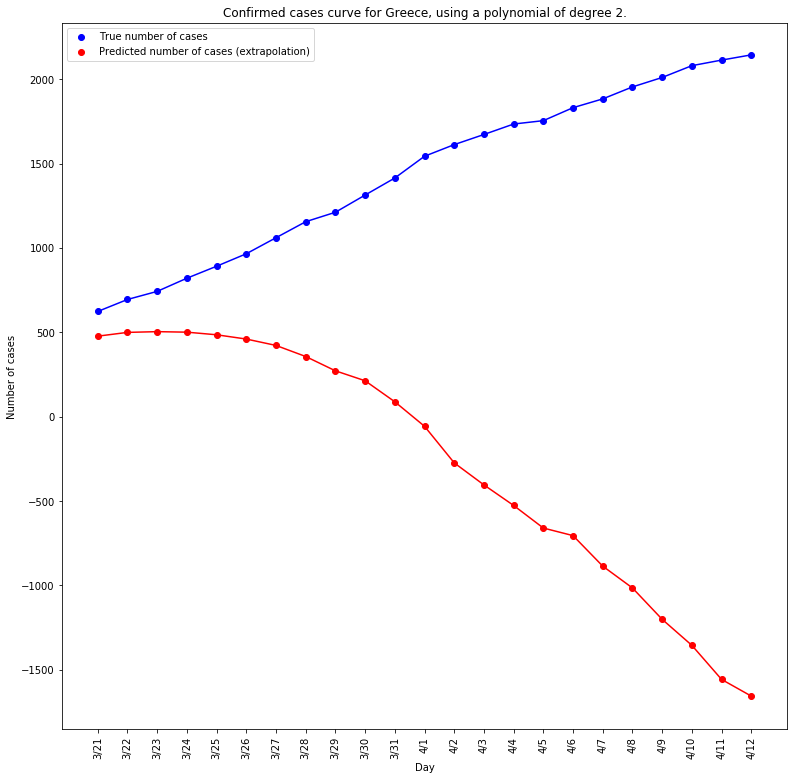

array([  477.50544592,   499.84911073,   504.26578361,   501.17649275,
         485.7034593 ,   460.36734156,   422.5483921 ,   356.92114427,
         272.09614599,   213.1003477 ,    88.50294245,   -56.67964964,
        -273.66751577,  -404.26152245,  -526.05369381,  -659.95057842,
        -704.88740499,  -885.83812067, -1015.17314747, -1201.05351102,
       -1355.22760798, -1557.326069  , -1656.21619094])

In [23]:
continued_predictions("Greece",best_params_greece,names['3/20/20'])

The same holds for Greece

[468.08931813810386, 607.4892064704992, 706.2490371188712, 742.1730220489092, 765.3557574020438, 905.4710205415331, 988.1422309348948, 1029.4055564507266, 1127.9613031321069, 1247.2390955842795, 1281.5094041146408, 1378.644415870537, 1525.834000833825, 1638.8439487544777, 1701.3567983473436, 1737.4174811290857, 1825.6107958782618, 1829.1471852944796, 1875.9353233276381, 1962.115007650557, 2002.0422717796807, 2062.8206566528415, 2141.4033529304706, 2169.154197084006]


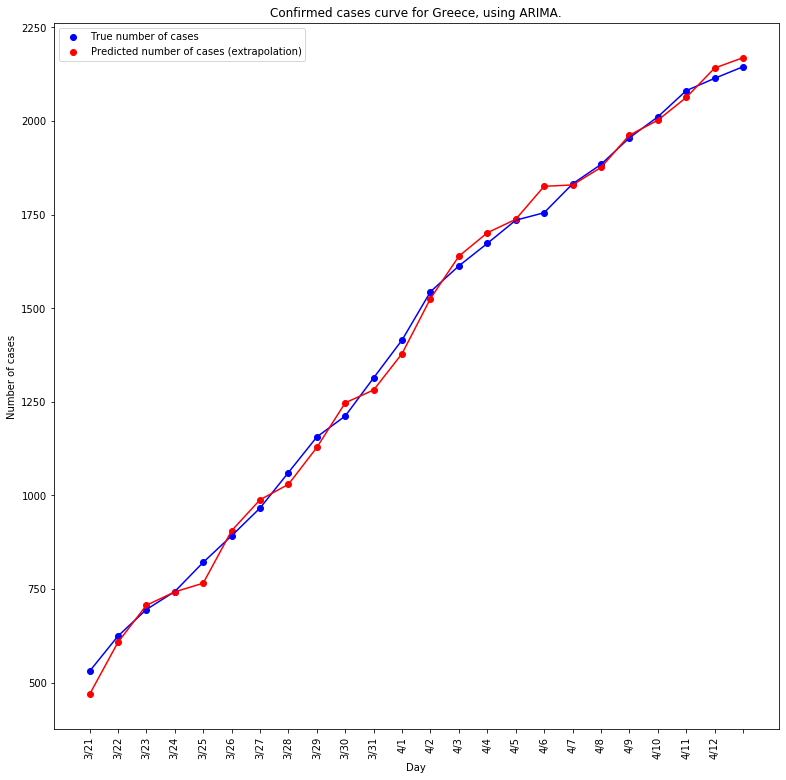

In [41]:
create_ARIMA_model(country = "Greece")

The following plot perfectly illustrates the inadequacy of the model and the importance of model selection. Since the model observed the data having an exponential distribution, it accounted for that and continued the trend, vastly overestimating the results. Data points are depicted in a logarithmic y scale so that the axes can be compared.

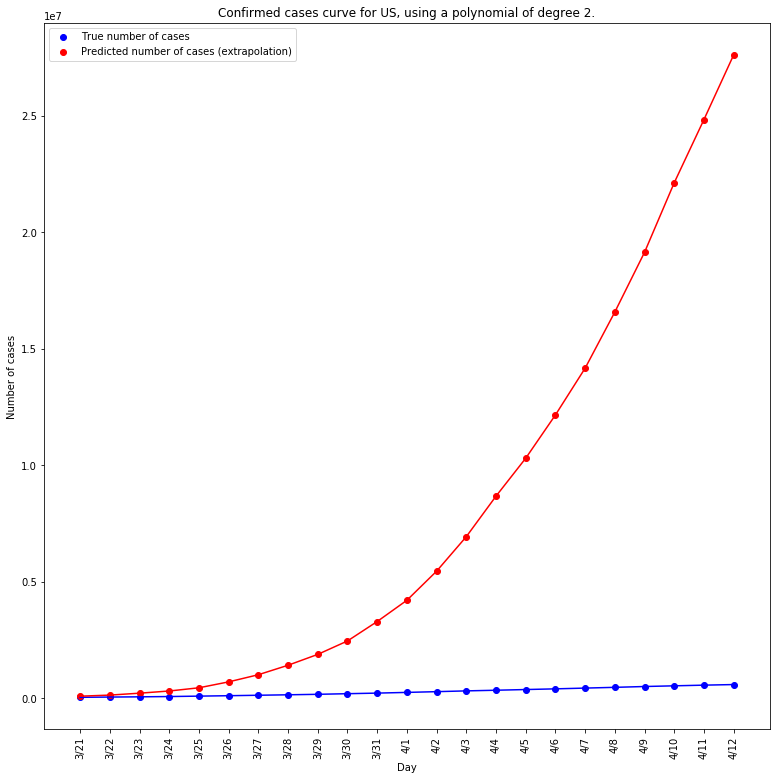

array([   81576.77059267,   128477.88352713,   210022.32014805,
         304131.69290475,   441851.44199291,   696212.8278357 ,
        1003437.9267874 ,  1410433.25563012,  1877034.73542557,
        2453337.35152362,  3288337.12416513,  4201332.6636777 ,
        5450855.19562782,  6933367.81873807,  8673435.31550663,
       10301971.29530126, 12160311.29293394, 14169871.82143217,
       16581987.62536397, 19147117.43524416, 22135325.14963338,
       24848159.67748151, 27624632.01578159])

In [42]:
continued_predictions("US",best_params_usa,names['3/20/20'])

[81130.70533387593, 81389.98642292338, 81506.7740030095, 81570.47616161592, 81678.70841005527, 81739.69372735954, 81866.44846294238, 81974.73560504068, 82081.02565666738, 82213.23166613752, 82276.60574009422, 82357.9527180164, 82433.69817998284, 82498.42118154487, 82575.18189210999, 82589.90315809978, 82655.79314911066, 82713.53905286957, 82763.09414685045, 82865.61715707478, 82937.6599715501, 82994.75512306871, 83072.67234080007, 83209.55370236967]


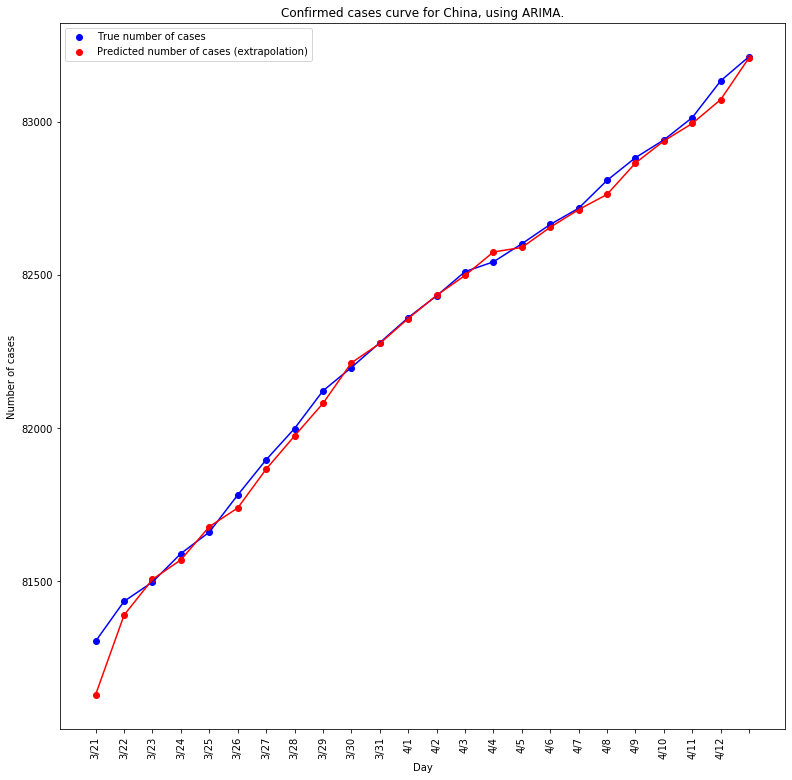

In [44]:
create_ARIMA_model(country = "China")

Working on solving some Linear Algebra errors when applying ARIMA to some countries, like the US.